# Format data on macroeconomic indicators for OECD cities

The data on macroeconomic indicators at the city level for this analysis has been obtained from the OECD:

<p><center> http://stats.oecd.org/Index.aspx?Datasetcode=CITIES </center></p>


The data on country-level indicators has been obtained via personal communication from Riccardo di Clemente at MIT.

# Packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

In [2]:
out_dir= "/home/data/world-cities/"

# Load & process macroeconomic data on cities

#### Read in different data sources

In [4]:
in_dir = "/home/data/oecd-city-data/"

population_df = pd.read_csv(in_dir + "CITIES_population.csv")
innovation_df = pd.read_csv(in_dir + "CITIES_patents.csv")
labormaket_df = pd.read_csv(in_dir + "CITIES_labour_market.csv")
inequality_df = pd.read_csv(in_dir + "CITIES_patents.csv")
envirnment_df = pd.read_csv(in_dir + "CITIES_environment.csv")
gdp_output_df = pd.read_csv(in_dir + "CITIES_gdp.csv")
admin_bnds_df = pd.read_csv(in_dir + "CITIES_admin.csv")

In [5]:
df_dict = dict(zip(["population", "innovation", "labormarket", "inequality", "envirnment", "gdp_output", "admin_bnds"], 
                   [population_df, innovation_df, labormaket_df, inequality_df, envirnment_df, 
                    gdp_output_df, admin_bnds_df]))

In [6]:
# Check the units of each variable (to expand any categorical variable)
# looks like all variables are real-valued

for k,v in df_dict.iteritems():
    print k
    print v[['VAR', 'Variables', 'Unit']].drop_duplicates()

labormarket
               VAR                                          Variables  \
0               LF                             Labour force (persons)   
14        LF_SHARE  Labour force of the metropolitan area as a sha...   
28             EMP                               Employment (persons)   
42       EMP_SHARE  Employment of the metropolitan area as a share...   
56           EMP_R  Employment as a share of the working age popul...   
70           UNEMP                             Unemployment (persons)   
84     UNEMP_SHARE  Unemployment of the metropolitan area as a sha...   
98         UNEMP_R    Unemployment as a share of the labour force (%)   
34508       PART_R                             Participation rate (%)   

             Unit  
0         Persons  
14     Percentage  
28        Persons  
42     Percentage  
56     Percentage  
70        Persons  
84     Percentage  
98     Percentage  
34508  Percentage  
admin_bnds
                    VAR                       

#### Combine data into a format suitable for ML

In [7]:
import re

def format_data(df0):
    df = df0.copy()
    df['country'] = df['METRO_ID'].apply(lambda x: " ".join(re.findall("[A-Z]+", x.upper())))
    df = df[df['Year']==min([df['Year'].max(),2012])] # only retain latest data available
    df['city'] = map(lambda x,y: x.lower() + ", " + y.lower(), 
                     df['Metropolitan areas'],
                     df['country'])
    var_key = dict(set(map(lambda x,y: (x,y), df['VAR'], df['Variables'])))
    df = df.pivot(index='city', columns="VAR", values="Value")
    df.columns = [c + "_" + k[:3].upper() for c in df.columns]
    return df, var_key

In [8]:
df_dict_wide = {}
vars_dict = {}
for k,v in df_dict.iteritems():
    df_dict_wide[k + "_wide"], d = format_data(v)
    d = dict(zip([x + "_" + k[:3].upper() for x in d.keys()], d.values()))
    vars_dict = dict(vars_dict.items() + d.items())
    

In [9]:
len(vars_dict)

36

In [10]:
vars_dict.keys()

['POP_DEP_RATIO_OLD_POP',
 'PCT_SHARE_INE',
 'PCT_INE',
 'UNEMP_SHARE_LAB',
 'CONCENTRATION_ADM',
 'PCT_SHARE_INN',
 'PCT_INN',
 'URB_AREA_ADM',
 'LF_LAB',
 'PART_R_LAB',
 'GDP_SHARE_GDP',
 'GDP_GDP',
 'FRAGMENTATION_ADM',
 'PCT_INTENSITY_INN',
 'PCT_INTENSITY_INE',
 'LABOUR_PRODUCTIVITY_GDP',
 'LOC_GOV_CORE_ADM',
 'POP_DEP_RATIO_YOUNG_POP',
 'POP_15_64_POP',
 'EMP_SHARE_LAB',
 'SURF_ADM',
 'POLY_ADM',
 'GREEN_AREA_PC_ENV',
 'GDP_PC_GDP',
 'EMP_R_LAB',
 'POP_65MORE_POP',
 'SURF_SHARE_ADM',
 'UNEMP_LAB',
 'POP_0_14_POP',
 'GREEN_AREA_PC_ADM',
 'AVG_POP_SIZE_GOV_ADM',
 'SPRAWL_ADM',
 'UNEMP_R_LAB',
 'EMP_LAB',
 'LOC_GOV_ADM',
 'LF_SHARE_LAB']

In [49]:
for k,v in df_dict_wide.iteritems():
    print k, ":", len(v)

admin_bnds_wide : 310
population_wide : 310
innovation_wide : 246
gdp_output_wide : 310
labormarket_wide : 309
inequality_wide : 246
envirnment_wide : 281


In [91]:
df_final = reduce(lambda left,right: left.join(right,how="outer"), 
                  df_dict_wide.values())

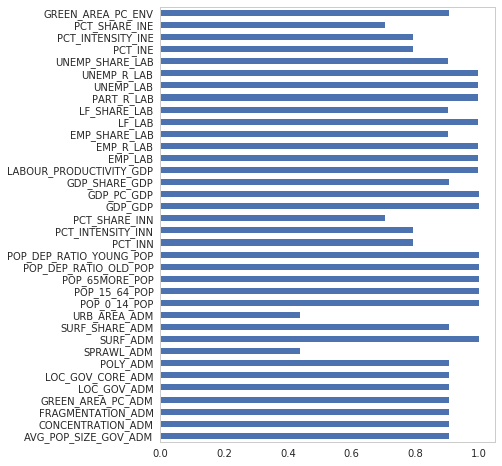

In [100]:
(df_final.count() / float(len(df_final))).plot(kind="barh", figsize=(6,8))

In [102]:
df_final.head()

,AVG_POP_SIZE_GOV_ADM,CONCENTRATION_ADM,FRAGMENTATION_ADM,GREEN_AREA_PC_ADM,LOC_GOV_ADM,LOC_GOV_CORE_ADM,POLY_ADM,SPRAWL_ADM,SURF_ADM,SURF_SHARE_ADM,...,LF_LAB,LF_SHARE_LAB,PART_R_LAB,UNEMP_LAB,UNEMP_R_LAB,UNEMP_SHARE_LAB,PCT_INE,PCT_INTENSITY_INE,PCT_SHARE_INE,GREEN_AREA_PC_ENV
city,,,,,,,,,,,,,,,,,,,,,
"aachen, de",48133.75,41.10,2.08,248.25,12.0,1.0,1.0,22.3,775.30,0.22,...,283102.0,0.67,72.21,16595.0,5.86,0.72,218.60,3.76,1.29,248.25
"acapulco de juárez, mex",808733.00,100.00,0.12,708.42,1.0,1.0,1.0,NaN,1731.31,0.09,...,336904.0,0.65,63.35,5370.0,1.59,0.22,0.68,0.01,0.31,708.42
"adelaide, aus",11730.28,87.09,8.52,29.05,109.0,87.0,2.0,NaN,3239.10,0.04,...,669000.0,5.59,78.21,37000.0,5.53,5.92,NaN,NaN,NaN,29.05
"aguascalientes, mex",250456.00,83.15,0.40,214.05,4.0,1.0,1.0,NaN,2308.08,0.12,...,419362.0,0.81,64.59,24949.0,5.95,1.01,1.80,0.02,0.81,214.05
"akron, us",16923.66,100.00,5.91,1286.63,32.0,32.0,1.0,NaN,1087.89,0.01,...,279593.0,0.18,76.83,19700.0,7.05,0.16,113.27,2.09,0.26,1286.63


In [105]:
df_final.to_csv(out_dir + "cities_macroeconomic_data.csv")

In [12]:
with gzip.open(out_dir + "cities_macroeconomic_variables.pickle.gz", "w") as f:
    pickle.dump(vars_dict, f)


# Load & preprocess data on countries

In [52]:
# load data on economic diversity and macroeconomic indicators

export_df = pd.read_csv(out_dir + "/Export_indicator_2014.txt", sep=",")
macro_df  = pd.read_csv(out_dir + "/Macro_indicator_2014.txt", sep=",", 
                        error_bad_lines=False)
country_df = pd.merge(macro_df, export_df, on="CountryName")
country_df['GDP'] = country_df['GDP'] / 1.0e9 # in $B
country_df['Export'] = country_df['Export'] / 1.0e9 # in $B
country_df.head()

,CountryName,Population,GDPpc,GDPgrowth,GINI,GDP,Export,RCA,Fitness,FitnessRank
0,Andorra,79218.0,0.000000,0.000000,0.000000,0.000000,0.000392,56,0.247816,93
1,Afghanistan,30551674.0,664.764589,1.934143,0.000000,20.309671,0.000768,62,0.132432,110
2,Angola,21471618.0,5783.366760,6.800058,11.479843,124.178242,0.054562,3,0.000000,147
3,Albania,2897366.0,4460.340971,1.417423,2.833538,12.923240,0.002287,140,0.433316,75
4,United Arab Emirates,9346129.0,43048.850149,5.199980,0.000000,402.340107,0.183298,79,0.235848,95


In [78]:
# add in country code & region info

regions_df = pd.read_csv(out_dir + "countries_regions.csv")
country2code = {r:c for r,c in zip(regions_df['name'], regions_df['alpha-2'].str.lower())}
country2subregion = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['sub-region'])}
country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}
country_df['code'] = country_df['CountryName'].apply(lambda x: country2code[x])
country_df['region'] = country_df['code'].apply(lambda x: country2region[x])
country_df['subregion'] = country_df['code'].apply(lambda x: country2subregion[x])

country_df.head()

,CountryName,Population,GDPpc,GDPgrowth,GINI,GDP,Export,RCA,Fitness,FitnessRank,code,region,subregion
0,Andorra,79218.0,0.000000,0.000000,0.000000,0.000000,0.000392,56,0.247816,93,ad,Europe,Southern Europe
1,Afghanistan,30551674.0,664.764589,1.934143,0.000000,20.309671,0.000768,62,0.132432,110,af,Asia,Southern Asia
2,Angola,21471618.0,5783.366760,6.800058,11.479843,124.178242,0.054562,3,0.000000,147,ao,Africa,Middle Africa
3,Albania,2897366.0,4460.340971,1.417423,2.833538,12.923240,0.002287,140,0.433316,75,al,Europe,Southern Europe
4,United Arab Emirates,9346129.0,43048.850149,5.199980,0.000000,402.340107,0.183298,79,0.235848,95,ae,Asia,Western Asia


In [79]:
country_df.to_csv(out_dir + "country_macro_indicators.csv", index=False)